# Streetcar Delay Prediction - Data Preparation

Use dataset covering Toronto Transit Commission (TTC) streetcar delays 2014 - present to predict future delays and come up with recommendations for avoiding delays.

Source dataset: : https://open.toronto.ca/dataset/ttc-streetcar-delay-data/

This notebook contains the common data loading and preparation steps:
- load data from all the tabs of all the XLS files into a single dataframe
- correct type issues
- fix missing values
- clean up anomalies in the location, direction and vehicle columns

# Streetcar routes

From https://www.ttc.ca/Routes/Streetcars.jsp

<table style="border: none" align="left">
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://raw.githubusercontent.com/ryanmark1867/streetcarnov3/master/streetcar%20routes.jpg" width="600" alt="Icon"> </th>
   </tr>
</table>

# Common imports and variables
Imports and variable definitions that are common to the entire notebook


In [342]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# import seaborn as sns
import datetime
import os


In [343]:
# common variables
# control whether to load data from scratch from original source or from saved dataframe
load_from_scratch = False
# control whether to save dataframe with transformed data
save_transformed_dataframe = True
# control whether rows containing erroneous values are removed from the saved dataset
remove_bad_values = True
# name of file containing pickled dataframe version of input (unprocessed) dataset
pickled_input_dataframe = '2014_2019_upto_june.pkl'
# name of file to which prepared data set is saved as a pickled dataframe
pickled_output_dataframe = '2014_2019_df_cleaned_remove_bad_sept18.pkl'


# Streetcar vehicle IDs CLRV/ALRV

From https://en.wikipedia.org/wiki/Toronto_streetcar_system_rolling_stock#CLRVs_and_ALRVs

<table style="border: none" align="left">
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://raw.githubusercontent.com/ryanmark1867/streetcarnov3/master/streetcarCLRV.jpg" width="600" alt="Icon"> </th>
   </tr>
</table>

In [344]:
streetcar_vehicles = list(range(4000,4005))+ list(range(4010,4200)) +  list(range(4200,4252)) + [4900]
streetcar_vehicles = streetcar_vehicles + [4400] + list(range(4402,4508))
print("valid streetcars",streetcar_vehicles)

valid streetcars [4000, 4001, 4002, 4003, 4004, 4010, 4011, 4012, 4013, 4014, 4015, 4016, 4017, 4018, 4019, 4020, 4021, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4052, 4053, 4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064, 4065, 4066, 4067, 4068, 4069, 4070, 4071, 4072, 4073, 4074, 4075, 4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4122, 4123, 4124, 4125, 4126, 4127, 4128, 4129, 4130, 4131, 4132, 4133, 4134, 4135, 4136, 4137, 4138, 4139, 4140, 4141, 4142, 4143, 4144, 4145, 4146, 4147, 4148, 4149, 4150, 4151, 4152, 4153, 4154, 4155, 4156, 4157, 4158, 4159, 4160, 4161, 4162, 4163, 4164, 4165, 4166, 4167, 4168

# Streetcar vehicle IDs Flexity

From https://en.wikipedia.org/wiki/Toronto_streetcar_system_rolling_stock#CLRVs_and_ALRVs

<table style="border: none" align="left">
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://raw.githubusercontent.com/ryanmark1867/streetcarnov3/master/streetcarflexity.jpg" width="600" alt="Icon"> </th>
   </tr>
</table>

# Bus identification
The following links define the valid non-streetcar vehicles that can be delayed by streetcar incidents

- Buses 1xxx: https://cptdb.ca/wiki/index.php/Toronto_Transit_Commission_1000-1149
- Buses 2xxx: https://cptdb.ca/wiki/index.php/Toronto_Transit_Commission_2000-2110,_2150-2155,_2240-2485,_2600-2619,_2700-2765,_2767-2858
- Buses 70xx: https://cptdb.ca/wiki/index.php/Toronto_Transit_Commission_7000-7134
- Buses 74xx: https://cptdb.ca/wiki/index.php/Toronto_Transit_Commission_7400-7499,_7500-7619,_7620-7881
- Buses 8xxx: https://cptdb.ca/wiki/index.php/Toronto_Transit_Commission_8000-8099
- Buses 9xxx: https://cptdb.ca/wiki/index.php/Toronto_Transit_Commission_9000-9026







In [345]:
bus_vehicles = list(range(1000,1150))+ list(range(2000,2111)) + list(range(2150,2156)) + list(range(2240,2486))
bus_vehicles = bus_vehicles + list(range(2600,2620)) + list(range(2700,2766)) + list(range(2767,2859))
bus_vehicles = bus_vehicles + list(range(7000,7135)) + list(range(7400,7450)) + list(range(7500,7620)) + list(range(7620,7882))
bus_vehicles = bus_vehicles + list(range(8000,8100)) + list(range(9000,9027))
valid_vehicles = streetcar_vehicles + bus_vehicles
print("valid vehicles",valid_vehicles)

valid vehicles [4000, 4001, 4002, 4003, 4004, 4010, 4011, 4012, 4013, 4014, 4015, 4016, 4017, 4018, 4019, 4020, 4021, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4052, 4053, 4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064, 4065, 4066, 4067, 4068, 4069, 4070, 4071, 4072, 4073, 4074, 4075, 4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4122, 4123, 4124, 4125, 4126, 4127, 4128, 4129, 4130, 4131, 4132, 4133, 4134, 4135, 4136, 4137, 4138, 4139, 4140, 4141, 4142, 4143, 4144, 4145, 4146, 4147, 4148, 4149, 4150, 4151, 4152, 4153, 4154, 4155, 4156, 4157, 4158, 4159, 4160, 4161, 4162, 4163, 4164, 4165, 4166, 4167, 4168, 

# Vehicles that are not legitimate subjects of streetcar incidents
The following vehicles are not legitimate subjects of streetcar incidents because they run on completely separate tracks (RT and subway) or they have been retired (6xxx buses).

- RT cars 3xxx: https://cptdb.ca/wiki/index.php/Toronto_Transit_Commission_3000-3027
- Subway cars 5xxx https://cptdb.ca/wiki/index.php/Toronto_Transit_Commission_5000-5371
- Retired Buses 6xxx: https://cptdb.ca/wiki/index.php/Toronto_Transit_Commission_6000-6122


In [346]:
# load the valid list of TTC Streetcar routes
valid_routes = ['501','502','503','504','505','506','509','510','511','512','301','304','306','310']

In [347]:
valid_routes

['501',
 '502',
 '503',
 '504',
 '505',
 '506',
 '509',
 '510',
 '511',
 '512',
 '301',
 '304',
 '306',
 '310']

In [348]:
# original valid directions
# valid_directions = ['E/B','W/B','N/B','S/B','B/W']
# revised valid directions to include lowercasing and removal of '/' and simplify to single letter
valid_directions = ['e','w','n','s','b']

In [349]:
valid_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# Load and Save Data
- parse list of XLS files 
- load XLS files, tab by tab, into dataframe
- pickle dataframe for future runs

In [350]:
# get the directory for that this notebook is in and return the directory containing data files

def get_path():
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'data')) + "/"
    return(path)


In [351]:
# given a path return the list of xls files in the directory
def get_xls_list(path):
    files = os.listdir(path)
    files_xls = [f for f in files if f[-4:] == 'xlsx']
    print(files)
    print(files_xls)
    return(files_xls)


In [352]:
# load all the tabs of all the XLS files in a list of XLS files, minus tab that has seeded dataframe
def load_xls(path, files_xls, firstfile, firstsheet, df):
    for f in files_xls:
        print("file name",f)
        xlsf = pd.ExcelFile(path+f)
        # iterate through sheets
        for sheet_name in xlsf.sheet_names:
            print("sheet_name",sheet_name)
            if (f != firstfile) or (sheet_name != firstsheet):
                print("sheet_name in loop",sheet_name)
                data = pd.read_excel(path+f,sheet_name=sheet_name)    
                df = df.append(data)
    return (df)

In [353]:
# given a path and a filename, load all the XLS files in the path into a dataframe and save
# to the dataframe to the filename
def reloader(path,picklename):
    # get list of all xls files in the path
    files_xls = get_xls_list(path)
    print("list of xls",files_xls)
    # seed initial tab on initial xls file
    dfnew = pd.read_excel(path+files_xls[0])
    # get the list of sheets in the first file
    xlsf = pd.ExcelFile(path+files_xls[0])
    # load the remaining tabs from all the other xls
    # pass the first file (files_xls[0]) and the first tab in that file (xlsf[0]) explicitly
    dflatest = load_xls(path,files_xls,files_xls[0],xlsf.sheet_names[0], dfnew)
    # save dataframe to pickle
    dflatest.to_pickle(path+ picklename)
    # return dataframe loaded with all tabs of all xls files
    return(dflatest)
    

In [354]:
# define categories for input columns
def define_feature_categories(df):
    allcols = list(df)
    print("all cols",allcols)
    textcols = ['Incident','Location'] # 
    continuouscols = ['Min Delay','Min Gap'] 
                      # columns to deal with as continuous values - no embeddings
    timecols = ['Report Date','Time']
    collist = ['Day','Vehicle','Route','Direction']
    for col in continuouscols:
        df[col] = df[col].astype(float)
    print('texcols: ',textcols)
    print('continuouscols: ',continuouscols)
    print('timecols: ',timecols)
    print('collist: ',collist)
    return(allcols,textcols,continuouscols,timecols,collist)

In [355]:
# fill missing values according to the column category
def fill_missing(dataset,allcols,textcols,continuouscols,timecols,collist):
    print("before mv")
    for col in collist:
        dataset[col].fillna(value="missing", inplace=True)
    for col in continuouscols:
        dataset[col].fillna(value=0.0,inplace=True)
    for col in textcols:
        dataset[col].fillna(value="missing", inplace=True)
    return (dataset)

# Load dataframe
- load pickled dataframe
- show info about the dataset


In [356]:
# read in data, either from original XLS files in data directory or from pickled dataframe containing
def ingest_data(path):
    if load_from_scratch:
        unpickled_df = reloader(path,pickled_input_dataframe)
        print("reloader done")
    else:
        unpickled_df = pd.read_pickle(path+pickled_input_dataframe)
    return(unpickled_df)

# General cleanup
- correct types for Route and Vehicle
- fill missing values
- create report-date-time index

In [357]:
# the dataset incorporated some anomalies in the 2019 data, including:
# extraneous Incident ID in April 2019 tab
# Gap and Delay columns in April and June 2019 tabs for what had otherwise been called Min Gap and Min Delay
# this function cleans up these anomalies
def fix_anomalous_columns(df):
    # for rows where there is NaN in the Min Delay or Min Gap columns, copy over value from Delay or Gap
    # df.Temp_Rating.fillna(df.Farheit, inplace=True)
    df['Min Delay'].fillna(df['Delay'], inplace=True)
    df['Min Gap'].fillna(df['Gap'], inplace=True)
    # now that the useful values have been copied from Delay and Gap, remove them
    del df['Delay']
    del df['Gap']
    # remove Incident ID column - it's extraneous
    del df['Incident ID']
    return(df)

In [358]:
def general_cleanup(df):
    # ensure Route and Vehicle are strings, not numeric
    df['Route'] = df['Route'].astype(str)
    df['Vehicle'] = df['Vehicle'].astype(str)
    # remove extraneous characters left from Vehicle values being floats
    df['Vehicle'] = df['Vehicle'].str[:-2]
    # tactical definition of categories
    allcols,textcols,continuouscols,timecols,collist = define_feature_categories(df)
    # fill in missing values
    df.isnull().sum(axis = 0)
    df = fix_anomalous_columns(df)
    df = fill_missing(df,allcols,textcols,continuouscols,timecols,collist)
    # create new column combing date + time (needed for resampling) and make it the index
    df['Report Date Time'] = pd.to_datetime(df['Report Date'].astype(str) + ' ' + df['Time'].astype(str))
    df.index = df['Report Date Time']
    # return the updated dataframe along with the column category lists
    return(df,allcols,textcols,continuouscols,timecols,collist)

# Master cell
This cell contains calls to the other functions in this notebook to complete the data preparation

In [359]:
# master cell to call the other functions
# get the path for data files
path = get_path()
print("path is",path)
# load route direction and delay data datframes
df = ingest_data(path)
print("number of records: ",len(df.index))
print("df.info() output",df.info())
print("df.shape output",df.shape)
print("df.describe() output",df.describe())
print("df.types output",df.dtypes)
df,allcols,textcols,continuouscols,timecols,collist = general_cleanup(df)
df.head()
# check that the values for April 2019 are correct
df[df['Report Date Time'].astype(str).str[:7]=='2019-04']


path is /storage/manning/data/
number of records:  73473
<class 'pandas.core.frame.DataFrame'>
Int64Index: 73473 entries, 0 to 760
Data columns (total 13 columns):
Day            73473 non-null object
Delay          1813 non-null float64
Direction      73196 non-null object
Gap            1806 non-null float64
Incident       73473 non-null object
Incident ID    889 non-null float64
Location       73232 non-null object
Min Delay      71595 non-null float64
Min Gap        71573 non-null float64
Report Date    73473 non-null datetime64[ns]
Route          73473 non-null int64
Time           73473 non-null object
Vehicle        68941 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(1), object(5)
memory usage: 7.8+ MB
df.info() output None
df.shape output (73473, 13)
df.describe() output              Delay          Gap  Incident ID     Min Delay       Min Gap  \
count  1813.000000  1806.000000   889.000000  71595.000000  71573.000000   
mean     15.492002    21.211517     3.9010

,Day,Direction,Incident,Location,Min Delay,Min Gap,Report Date,Route,Time,Vehicle,Report Date Time
Report Date Time,,,,,,,,,,,
2019-04-01 04:26:00,Monday,E/B,Mechanical,Roncesvalles Yard.,10.0,20.0,2019-04-01,512,04:26:00,4460,2019-04-01 04:26:00
2019-04-01 04:27:00,Monday,E/B,Mechanical,Queen St. E and Woodfield Ave.,17.0,17.0,2019-04-01,501,04:27:00,4189,2019-04-01 04:27:00
2019-04-01 04:37:00,Monday,W/B,Mechanical,Queen St. E at Greenwood Ave.,5.0,10.0,2019-04-01,501,04:37:00,4012,2019-04-01 04:37:00
2019-04-01 04:46:00,Monday,E/B,Mechanical,Queen St E at Woodfield Ave,6.0,4.0,2019-04-01,501,04:46:00,4039,2019-04-01 04:46:00
2019-04-01 05:00:00,Monday,N/B,Mechanical,King and Spadina,11.0,0.0,2019-04-01,510,05:00:00,4465,2019-04-01 05:00:00
2019-04-01 05:25:00,Monday,W/B,Held By,Queen St. E at Greenwood Ave.,1.0,2.0,2019-04-01,501,05:25:00,4121,2019-04-01 05:25:00
2019-04-01 05:31:00,Monday,W/B,Mechanical,Queen St. E at Greenwood Ave.,4.0,9.0,2019-04-01,501,05:31:00,4117,2019-04-01 05:31:00
2019-04-01 05:41:00,Monday,E/B,Mechanical,Coxwell Ave. and Lower Gerrard St.,6.0,16.0,2019-04-01,506,05:41:00,4141,2019-04-01 05:41:00
2019-04-01 05:41:00,Monday,W/B,Mechanical,Queen St. E at Greenwood Ave.,5.0,10.0,2019-04-01,501,05:41:00,4114,2019-04-01 05:41:00


# Clean up selected columns
Some values in the input dataset were entered "free form" when they should have been constricted to a pick list. Columns with this problem include:

- Route
- Vehicle
- Direction
- Location


Each of these have a finite set of valid values. We have to fix the data in these columns where multiple tokens have been used to signify the same real-world entity (e.g. "roncesvalles yard." and "roncesvalles carhouse", or where incorrect values have been entered (e.g. Direction that does not correspond with a compass point)

# Clean up Route

In [281]:
def check_route (x):
    if x in valid_routes:
        return(x)
    else:
        return("bad route")

In [282]:
print("route count",df['Route'].nunique())
df['Route'].value_counts()

route count 109


501    18117
504    13919
506     9870
505     7869
512     5552
510     4701
511     3701
509     2523
502     1520
514     1500
503      954
301      820
306      344
705      214
304      193
805      156
508      137
50        45
310       43
535       41
317       37
51        21
807       20
5         20
1         16
500       12
4          9
3          8
11         8
201        7
       ...  
63         1
85         1
804        1
519        1
13         1
111        1
32         1
403        1
596        1
595        1
204        1
64         1
830        1
93         1
52         1
205        1
60         1
86         1
53         1
21         1
61         1
513        1
210        1
45         1
594        1
31         1
19         1
80         1
68         1
701        1
Name: Route, Length: 109, dtype: int64

In [283]:
print("route count pre cleanup",df['Route'].nunique())

route count pre cleanup 109


In [284]:
# apply(lambda x:findEmpty(x) df['Route'].apply(lambda x:check_route(x))
df['Route'] = df['Route'].apply(lambda x:check_route(x))

In [285]:
print("route count post cleanup",df['Route'].nunique())
df['Route'].value_counts()

route count post cleanup 15


501          18117
504          13919
506           9870
505           7869
512           5552
510           4701
511           3701
509           2523
bad route     2418
502           1520
503            954
301            820
306            344
304            193
310             43
Name: Route, dtype: int64

# Clean up Vehicle

In [286]:
df[df.Vehicle == 'n'].shape[0]

4511

In [287]:
df['Vehicle'].shape[0]

72544

In [288]:
def check_vehicle (x):
    if str.isdigit(x):
        if int(x) in valid_vehicles:
            return x
        else:
            return("bad vehicle")
    else:
        return("bad vehicle")

In [289]:
df['Vehicle'].value_counts()

n       4511
4074     291
4101     272
4001     266
4115     265
4199     264
4176     262
4050     261
4185     260
4147     259
4247     257
4141     256
4145     256
4189     255
4144     254
4110     254
4209     254
4079     252
4048     252
4012     251
4111     250
4218     247
4149     246
4114     246
4184     246
4077     246
4222     244
4066     244
4181     244
4403     243
        ... 
6875       1
9332       1
8601       1
7576       1
3275       1
6955       1
8691       1
8678       1
7972       1
8443       1
7344       1
1262       1
5052       1
8556       1
8256       1
8894       1
7407       1
4721       1
1238       1
8883       1
7677       1
830        1
422        1
8885       1
7432       1
7416       1
8549       1
2310       1
8492       1
416        1
Name: Vehicle, Length: 2504, dtype: int64

In [290]:
print("vehicle count pre cleanup",df['Vehicle'].nunique())
df['Vehicle'] = df['Vehicle'].apply(lambda x:check_vehicle(x))
print("vehicle count post cleanup",df['Vehicle'].nunique())
df['Vehicle'].value_counts()

vehicle count pre cleanup 2504
vehicle count post cleanup 1017


bad vehicle    12089
4074             291
4101             272
4001             266
4115             265
4199             264
4176             262
4050             261
4185             260
4147             259
4247             257
4145             256
4141             256
4189             255
4144             254
4110             254
4209             254
4048             252
4079             252
4012             251
4111             250
4218             247
4077             246
4184             246
4149             246
4114             246
4066             244
4222             244
4181             244
4195             243
               ...  
7439               1
7691               1
7077               1
8002               1
8010               1
7814               1
7594               1
7423               1
7404               1
2385               1
7592               1
7521               1
7589               1
7415               1
7639               1
7638               1
7572         

# Clean up Direction

In [291]:
def check_direction (x):
    if x in valid_directions:
        return(x)
    else:
        return("bad direction")

In [292]:
df['Direction'].shape[0]

72544

In [293]:
# prior to cleanup of the Direction column, get a look at the values
df['Direction'].value_counts()

W/B                  28657
E/B                  27978
N/B                   5158
S/B                   4936
B/W                   4818
missing                264
eb                     166
EB                     137
WB                     107
wb                     101
nb                      17
SB                      17
NB                      15
sb                      13
EW                      12
bw                      10
eastbound                8
w/b                      7
w                        6
5                        6
BW                       4
E                        4
2                        3
10                       3
s                        3
Service adjusted.        3
b/w                      3
W                        3
ew                       3
8                        3
                     ...  
18                       1
1114                     1
19                       1
ss                       1
1573                     1
33                       1
S

In [294]:
# to have consistent checking of directions: lowercase and remove '/'
print("Unique directions before cleanup:",df['Direction'].nunique())
df['Direction'] = df['Direction'].str.lower()
df['Direction'] = df['Direction'].str.replace('/','')
df['Direction'] = df['Direction'].replace({'eb':'e','wb':'w','sb':'s','nb':'n','bw':'b'})
df['Direction'] = df['Direction'].replace({'eastbound':'e','westbound':'w','southbound':'s','northbound':'n'})
# replace any remaining bad Direction values with a common token
df['Direction'] = df['Direction'].apply(lambda x:check_direction(x))
print("Unique directions after cleanup:",df['Direction'].nunique())

Unique directions before cleanup: 98
Unique directions after cleanup: 6


In [295]:
print("Unique directions after cleanup:",df['Direction'].nunique())

Unique directions after cleanup: 6


In [296]:
print("direction count",df['Direction'].nunique())
df['Direction'].value_counts()

direction count 6


w                28885
e                28298
n                 5193
s                 4971
b                 4837
bad direction      360
Name: Direction, dtype: int64

In [297]:
df.head()

,Day,Delay,Direction,Gap,Incident,Incident ID,Location,Min Delay,Min Gap,Report Date,Route,Time,Vehicle,Report Date Time
Report Date Time,,,,,,,,,,,,,,
2016-01-01 00:00:00,Friday,NaN,w,NaN,General Delay,NaN,Dundas West stnt to Broadview stn,7.0,14.0,2016-01-01,505,00:00:00,4028,2016-01-01 00:00:00
2016-01-01 02:14:00,Friday,NaN,e,NaN,Mechanical,NaN,Fleet St. and Strachan Ave.,10.0,20.0,2016-01-01,511,02:14:00,4018,2016-01-01 02:14:00
2016-01-01 02:22:00,Friday,NaN,w,NaN,Mechanical,NaN,Queen St. West and Roncesvalles Ave.,9.0,18.0,2016-01-01,301,02:22:00,4201,2016-01-01 02:22:00
2016-01-01 03:28:00,Friday,NaN,e,NaN,Mechanical,NaN,Lake Shore Blvd. and Superior St.,20.0,40.0,2016-01-01,301,03:28:00,4251,2016-01-01 03:28:00
2016-01-01 14:28:00,Friday,NaN,e,NaN,Mechanical,NaN,Roncy to Neville Park,6.0,12.0,2016-01-01,501,14:28:00,4242,2016-01-01 14:28:00


# Clean up Location

In [298]:
def clean_conjunction(intersection):
    # make conjunctions in intersections consistent
    if " and " not in intersection:
        if "&" in intersection:
            if " & " in intersection:
                intersection.replace(" & "," and ")
            else:
                if "&" in intersection:
                    intersection.replace("&"," and ")
        else:
            if " / " in intersection:
                intersection.replace(" / "," and ")
            else:
                if "/" in intersection:
                    intersection.replace("/"," and ")
    return(intersection)

In [299]:
def order_location(intersection):
    # for any string with the format "* and *" if the value before the and is alphabetically
    # higher than the value after the and, swap the values
    conj = " and "
    alpha_ordered_intersection = intersection
    if conj in intersection:
        end_first_street = intersection.find(conj)
        if (end_first_street > 0) and (len(intersection) > (end_first_street + len(conj))):
            start_second_street = intersection.find(conj) + len(conj)
            first_street = intersection[0:end_first_street]
            second_street = intersection[start_second_street:]
            alpha_ordered_intersection = min(first_street,second_street)+conj+max(first_street,second_street)
    return(alpha_ordered_intersection)

In [300]:
df['Location'].value_counts().head(100)

Russell Yard                 1078
Queen and Connaught           992
Leslie Barns                  838
Roncesvalles Yard             777
Queen and Roncesvalles        752
Roncesvalles and Queen        740
Roncy Yard                    630
Queen at Connaught            539
Broadview Station             526
Broadview and Queen           523
Dundas West Station           495
Humber Loop                   483
CNE Loop                      426
Spadina and King              415
Broadview Stn                 408
Queen and Broadview           393
King and Spadina              390
Roncesvalles Yard.            373
Coxwell and Gerrard           363
Neville Loop                  341
Queen at Roncesvalles         319
Main Station                  318
Bingham Loop                  306
Broadview and Dundas          301
Bathurst Station              285
Russell yard                  279
Ronc. Carhouse.               268
Roncy yard                    258
Spadina Station               252
Exhibition Loo

In [301]:
# the values in the location column were entered in free form, so there are several problems to fix

# start by counting the distinct values in location column before and after lowercasing
print("Location count pre cleanup:",df['Location'].nunique())
print("Route count pre cleanup:",df['Route'].nunique())
print("Direction count pre cleanup:",df['Direction'].nunique())
print("Vehicle count pre cleanup:",df['Vehicle'].nunique())
df['Location'] = df['Location'].str.lower()
print("Unique Location values after lcasing:",df['Location'].nunique())
df['Location'].value_counts().head(100)

Location count pre cleanup: 16218
Route count pre cleanup: 15
Direction count pre cleanup: 6
Vehicle count pre cleanup: 1017
Unique Location values after lcasing: 13685


russell yard                 1444
queen and connaught          1063
roncy yard                    937
roncesvalles yard             906
leslie barns                  894
roncesvalles and queen        777
queen and roncesvalles        771
broadview station             762
dundas west station           749
cne loop                      710
humber loop                   671
broadview stn                 574
broadview and queen           551
queen at connaught            549
spadina and king              444
main station                  431
king and spadina              429
roncesvalles yard.            427
coxwell and gerrard           421
queen and broadview           409
bathurst station              409
neville loop                  406
dundas west stn               380
bingham loop                  379
spadina station               373
queen at roncesvalles         326
broadview and dundas          317
exhibition loop               289
high park loop                271
ronc. carhouse

In [302]:
# count subset of locations that are explicitly junctions
# df[df['regiment'].str.contains(r"\bgoons\b", case = False)]
df[df['Location'].str.contains(" and ")].shape

(27822, 14)

In [303]:
df['Location'].shape

(72544,)

In [304]:
# make substitutions to eliminate obvious duplicate tokens, counting unique values before and after
# need to add a function to flip "x and y" consistently
print("Unique Location values before substitutions:",df['Location'].nunique())
df['Location'] = df['Location'].replace({'broadviewstation':'broadview station',' at ':' and ',' stn':' station',' ave.':'','/':' and ','roncy':'roncesvalles','carhouse':'yard','yard.':'yard','st. clair':'st clair','ronc. ':'roncesvalles ','long branch':'longbranch','garage':'yard','barns':'yard',' & ':' and '}, regex=True)
print("Unique Location values after substitutions:",df['Location'].nunique())
df['Location'].value_counts().head(50)

Unique Location values before substitutions: 13685
Unique Location values after substitutions: 11225


roncesvalles yard               3233
queen and connaught             1872
russell yard                    1651
roncesvalles and queen          1439
broadview station               1336
queen and roncesvalles          1267
dundas west station             1129
leslie yard                      964
broadview and queen              717
cne loop                         710
humber loop                      671
king and spadina                 669
spadina and king                 652
bathurst station                 643
queen and broadview              609
main station                     580
spadina station                  563
broadview and dundas             500
coxwell and gerrard              500
longbranch loop                  490
st clair west station            432
neville loop                     406
king and bathurst                403
bingham loop                     379
bathurst and king                376
broadview and gerrard            362
howard park and roncesvalles     307
g

In [305]:
# put intersection values into consistent order
print("Unique Location values:",df['Location'].nunique())
df['Location'] = df['Location'].apply(lambda x:order_location(x))
print("Location values post cleanup:",df['Location'].nunique())
df['Location'].value_counts().head(100)

Unique Location values: 11225
Location values post cleanup: 10407


roncesvalles yard               3233
queen and roncesvalles          2706
connaught and queen             2094
russell yard                    1651
broadview station               1336
broadview and queen             1326
king and spadina                1321
dundas west station             1129
leslie yard                      964
coxwell and gerrard              800
bathurst and king                779
broadview and dundas             730
cne loop                         710
humber loop                      671
bathurst station                 643
broadview and gerrard            594
main station                     580
spadina station                  563
howard park and roncesvalles     559
queen and spadina                496
longbranch loop                  490
bathurst and st clair            467
st clair west station            432
bathurst and fleet               416
bathurst and queen               410
neville loop                     406
bingham loop                     379
b

In [306]:
df['Location'].value_counts().head(80)

roncesvalles yard                           3233
queen and roncesvalles                      2706
connaught and queen                         2094
russell yard                                1651
broadview station                           1336
broadview and queen                         1326
king and spadina                            1321
dundas west station                         1129
leslie yard                                  964
coxwell and gerrard                          800
bathurst and king                            779
broadview and dundas                         730
cne loop                                     710
humber loop                                  671
bathurst station                             643
broadview and gerrard                        594
main station                                 580
spadina station                              563
howard park and roncesvalles                 559
queen and spadina                            496
longbranch loop     

In [307]:
df.head()

,Day,Delay,Direction,Gap,Incident,Incident ID,Location,Min Delay,Min Gap,Report Date,Route,Time,Vehicle,Report Date Time
Report Date Time,,,,,,,,,,,,,,
2016-01-01 00:00:00,Friday,NaN,w,NaN,General Delay,NaN,dundas west stationt to broadview station,7.0,14.0,2016-01-01,505,00:00:00,4028,2016-01-01 00:00:00
2016-01-01 02:14:00,Friday,NaN,e,NaN,Mechanical,NaN,fleet st. and strachan,10.0,20.0,2016-01-01,511,02:14:00,4018,2016-01-01 02:14:00
2016-01-01 02:22:00,Friday,NaN,w,NaN,Mechanical,NaN,queen st. west and roncesvalles,9.0,18.0,2016-01-01,301,02:22:00,4201,2016-01-01 02:22:00
2016-01-01 03:28:00,Friday,NaN,e,NaN,Mechanical,NaN,lake shore blvd. and superior st.,20.0,40.0,2016-01-01,301,03:28:00,4251,2016-01-01 03:28:00
2016-01-01 14:28:00,Friday,NaN,e,NaN,Mechanical,NaN,roncesvalles to neville park,6.0,12.0,2016-01-01,501,14:28:00,4242,2016-01-01 14:28:00


# Remove bad rows

In [308]:
print("Location count post cleanup:",df['Location'].nunique())
print("Route count post cleanup:",df['Route'].nunique())
print("Direction count post cleanup:",df['Direction'].nunique())
print("Vehicle count post cleanup:",df['Vehicle'].nunique())
# print("Bad Location count":df[df.Vehicle == 'bad vehicle'].shape[0])
print("Bad route count:",df[df.Route == 'bad route'].shape[0])
print("Bad direction count:",df[df.Direction == 'bad direction'].shape[0])
print("Bad vehicle count:",df[df.Vehicle == 'bad vehicle'].shape[0])

Location count post cleanup: 10407
Route count post cleanup: 15
Direction count post cleanup: 6
Vehicle count post cleanup: 1017
Bad route count: 2418
Bad direction count: 360
Bad vehicle count: 12089


In [309]:
# remove rows with bad vehicle value
if remove_bad_values:
    df = df[df.Vehicle != 'bad vehicle']
    df = df[df.Direction != 'bad direction']
    df = df[df.Route != 'bad route']

In [310]:
df.shape

(58223, 14)

In [311]:
# pickle the cleansed dataframe
file_name = path + pickled_output_dataframe
df.to_pickle(file_name)

In [312]:
dfn = pd.read_pickle(file_name)
dfn.head()

,Day,Delay,Direction,Gap,Incident,Incident ID,Location,Min Delay,Min Gap,Report Date,Route,Time,Vehicle,Report Date Time
Report Date Time,,,,,,,,,,,,,,
2016-01-01 00:00:00,Friday,NaN,w,NaN,General Delay,NaN,dundas west stationt to broadview station,7.0,14.0,2016-01-01,505,00:00:00,4028,2016-01-01 00:00:00
2016-01-01 02:14:00,Friday,NaN,e,NaN,Mechanical,NaN,fleet st. and strachan,10.0,20.0,2016-01-01,511,02:14:00,4018,2016-01-01 02:14:00
2016-01-01 02:22:00,Friday,NaN,w,NaN,Mechanical,NaN,queen st. west and roncesvalles,9.0,18.0,2016-01-01,301,02:22:00,4201,2016-01-01 02:22:00
2016-01-01 03:28:00,Friday,NaN,e,NaN,Mechanical,NaN,lake shore blvd. and superior st.,20.0,40.0,2016-01-01,301,03:28:00,4251,2016-01-01 03:28:00
2016-01-01 14:28:00,Friday,NaN,e,NaN,Mechanical,NaN,roncesvalles to neville park,6.0,12.0,2016-01-01,501,14:28:00,4242,2016-01-01 14:28:00


# Visualize cleaned data

In [313]:
!pip install pixiedust

In [314]:
import pixiedust


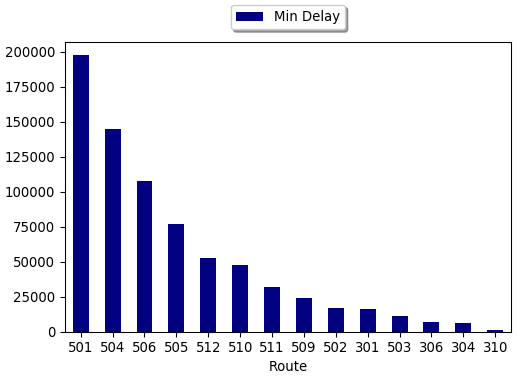

In [ ]:
display(df)